In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from correlation import Correlation, CorrBar, SeasonSplit
from merge_module import Split_area
from visualization import Monthly_plot, Day_plot

# Load

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/MapDf.csv') 
print(df.shape)
df

(129117, 17)


,Date,Area,Time,Photovoltaics,PM10,PM25,Temperature,Precipitation,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,1,0.0,44.0,NaN,-2.2,NaN,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,1
1,2013-01-01,전남 목포시,2,0.0,34.0,NaN,-2.4,NaN,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,NaN,1
2,2013-01-01,전남 목포시,3,0.0,41.0,NaN,-2.7,NaN,3.6,160.0,95.0,1020.8,NaN,NaN,7.0,1800.0,1
3,2013-01-01,전남 목포시,4,0.0,41.0,NaN,-2.9,NaN,4.0,160.0,94.0,1020.0,NaN,NaN,7.0,1800.0,1
4,2013-01-01,전남 목포시,5,0.0,35.0,NaN,-2.4,NaN,3.0,160.0,91.0,1019.3,NaN,NaN,10.0,1200.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129112,2020-11-16,경남 진주시,20,0.0,NaN,NaN,10.5,NaN,0.3,0.0,73.0,1026.2,NaN,NaN,7.0,1422.0,11
129113,2020-11-16,경남 진주시,21,0.0,NaN,NaN,11.1,NaN,0.1,0.0,75.0,1026.3,NaN,NaN,10.0,1285.0,11
129114,2020-11-16,경남 진주시,22,0.0,NaN,NaN,10.6,NaN,0.3,0.0,74.0,1026.9,NaN,NaN,8.0,1169.0,11
129115,2020-11-16,경남 진주시,23,0.0,NaN,NaN,10.1,NaN,0.4,0.0,77.0,1026.9,NaN,NaN,9.0,1233.0,11


In [ ]:
df.isnull().sum()

Date                       0
Area                       0
Time                       0
Photovoltaics             18
PM10                    9504
PM25                   51652
Temperature               48
Precipitation         117313
Wind velocity             80
Wind direction           699
Humidity                 493
Sea-level pressure       148
Sunshine               58717
Solar radiation        58504
Cloudy                 39113
Visibility              4303
Month                      0
dtype: int64

In [ ]:
df.drop(columns='Precipitation', inplace=True) #결측치가 많은 변수 제거  
df.head(2)

,Date,Area,Time,Photovoltaics,PM10,PM25,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Sunshine,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,1,0.0,44.0,NaN,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,NaN,1
1,2013-01-01,전남 목포시,2,0.0,34.0,NaN,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,NaN,1


In [ ]:
area_list = ['전남 목포시', '강원 강릉시', '경남 진주시']
Mp_df, Gn_df, Jj_df = Split_area(df, 'Area', area_list)

전체 : (129117, 16)
['전남 목포시'] : (60796, 16)
['강원 강릉시'] : (35063, 16)
['경남 진주시'] : (33258, 16)


#Photovoltaics plot

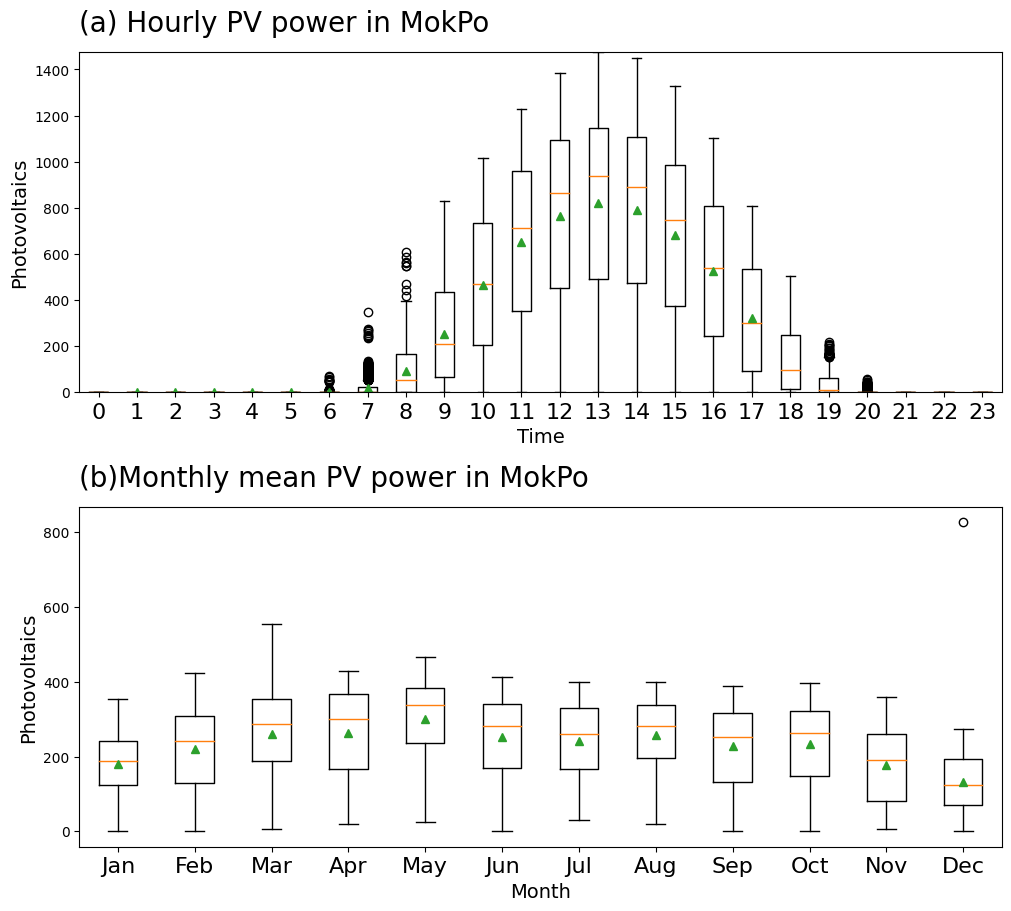

In [ ]:
Monthly_plot(Mp_df, 'Photovoltaics', 'MokPo')

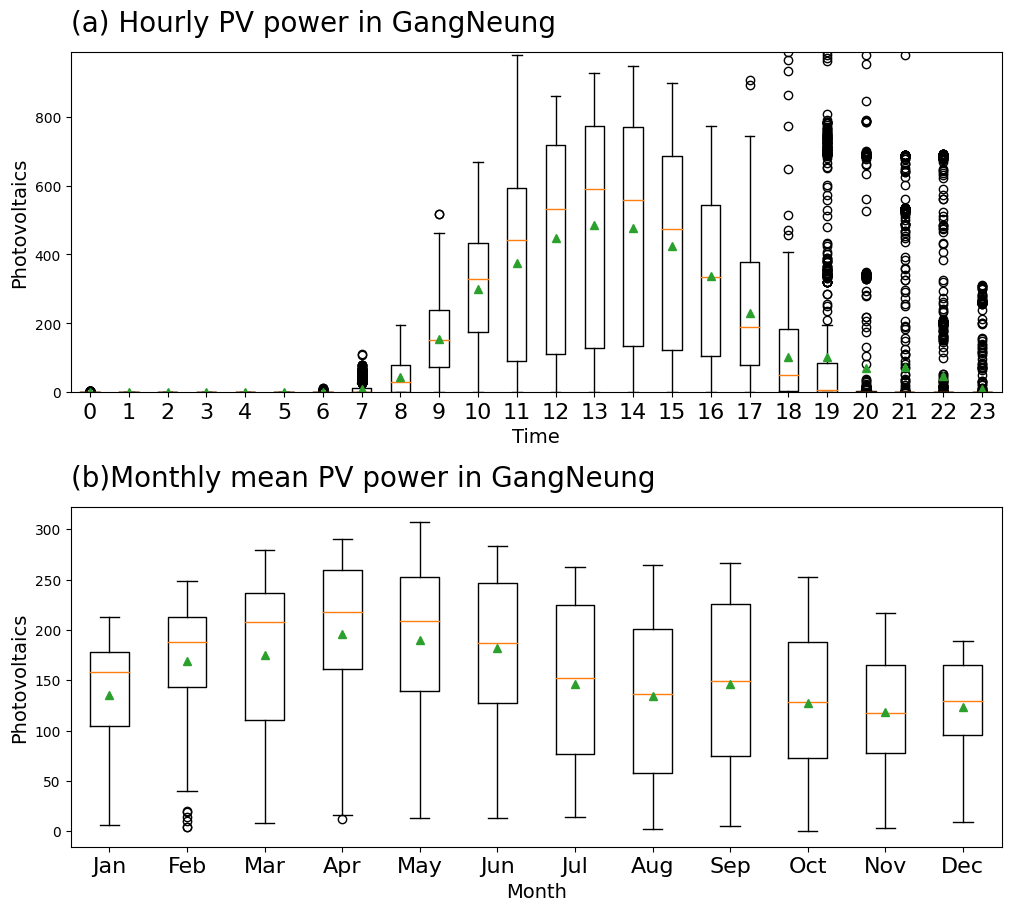

In [ ]:
Monthly_plot(Gn_df, 'Photovoltaics', 'GangNeung')

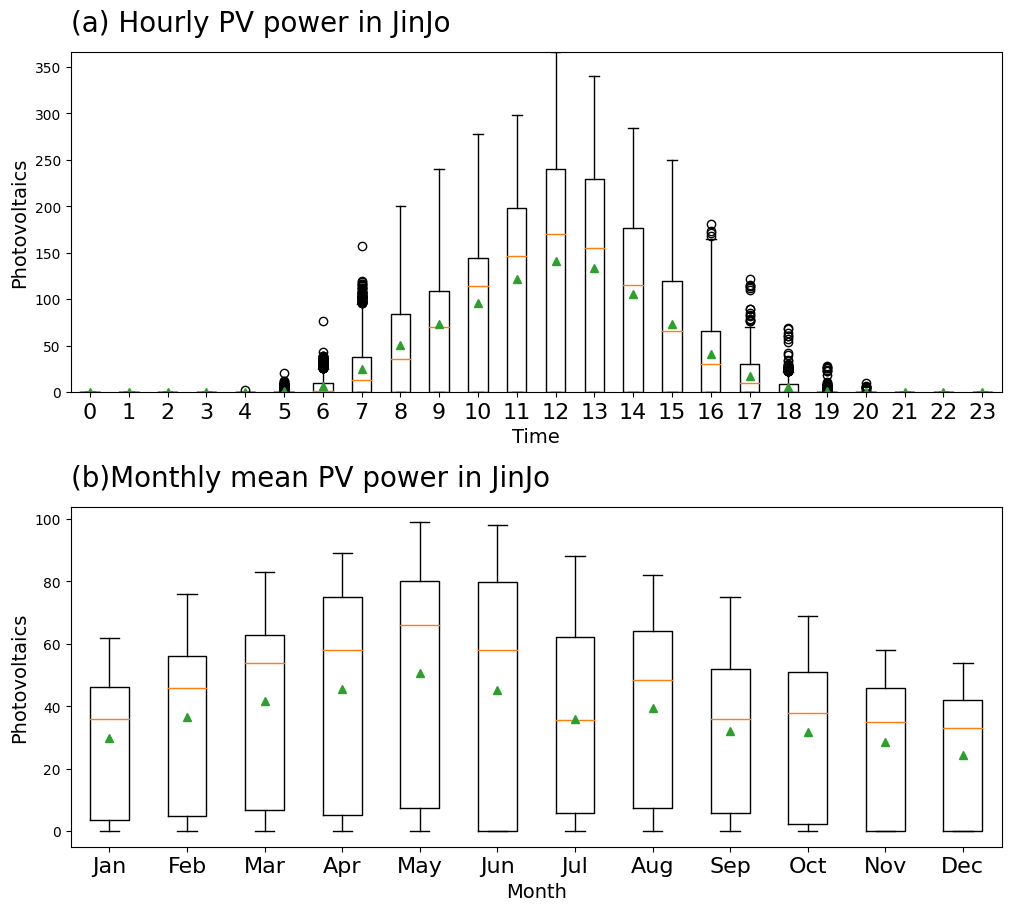

In [ ]:
Monthly_plot(Jj_df, 'Photovoltaics', 'JinJo')

# Day plot

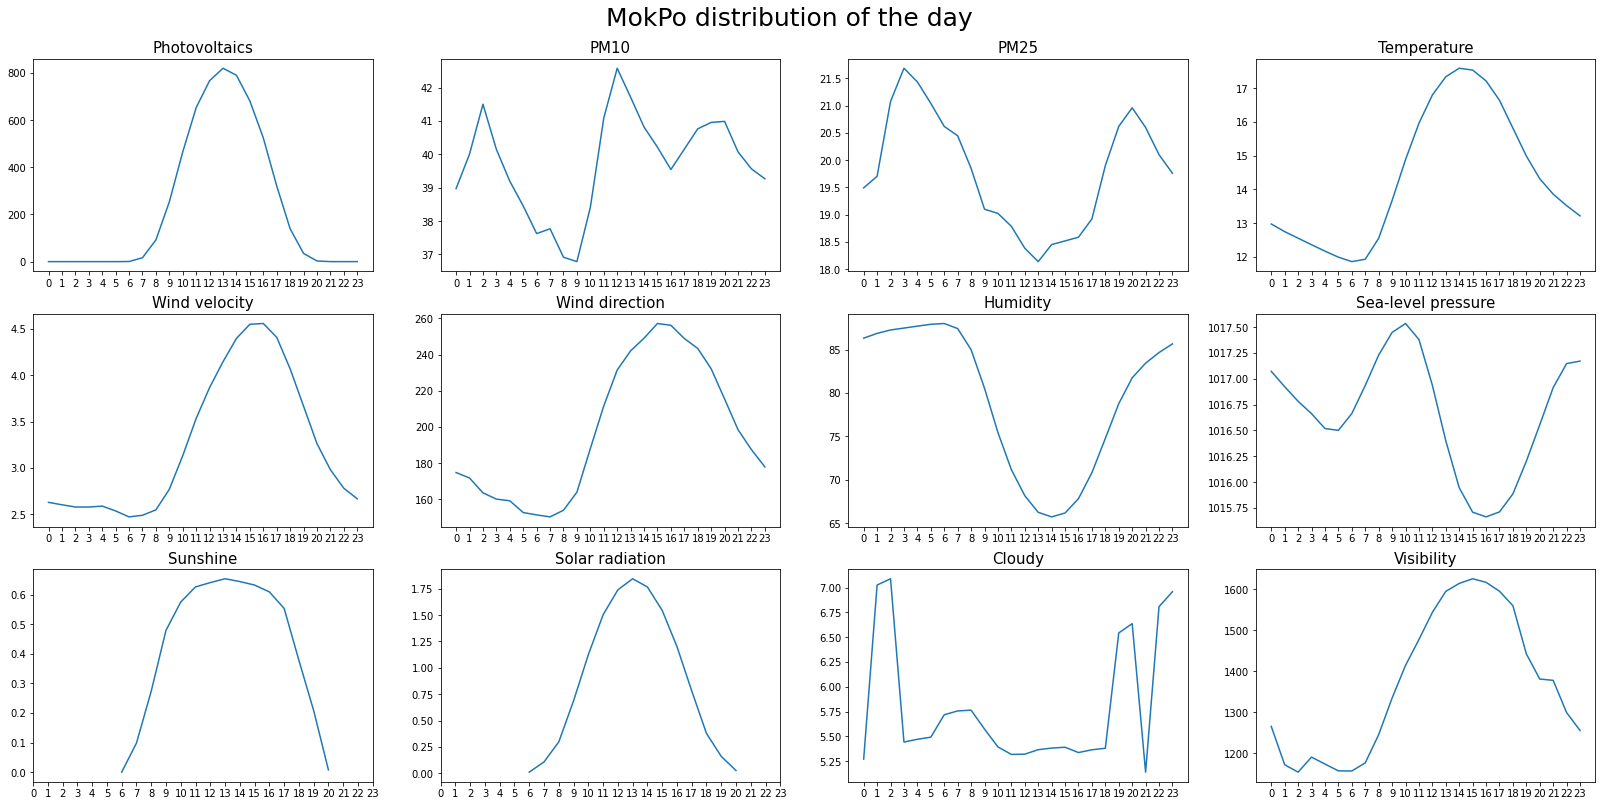

In [ ]:
Day_plot(Mp_df, 'MokPo')

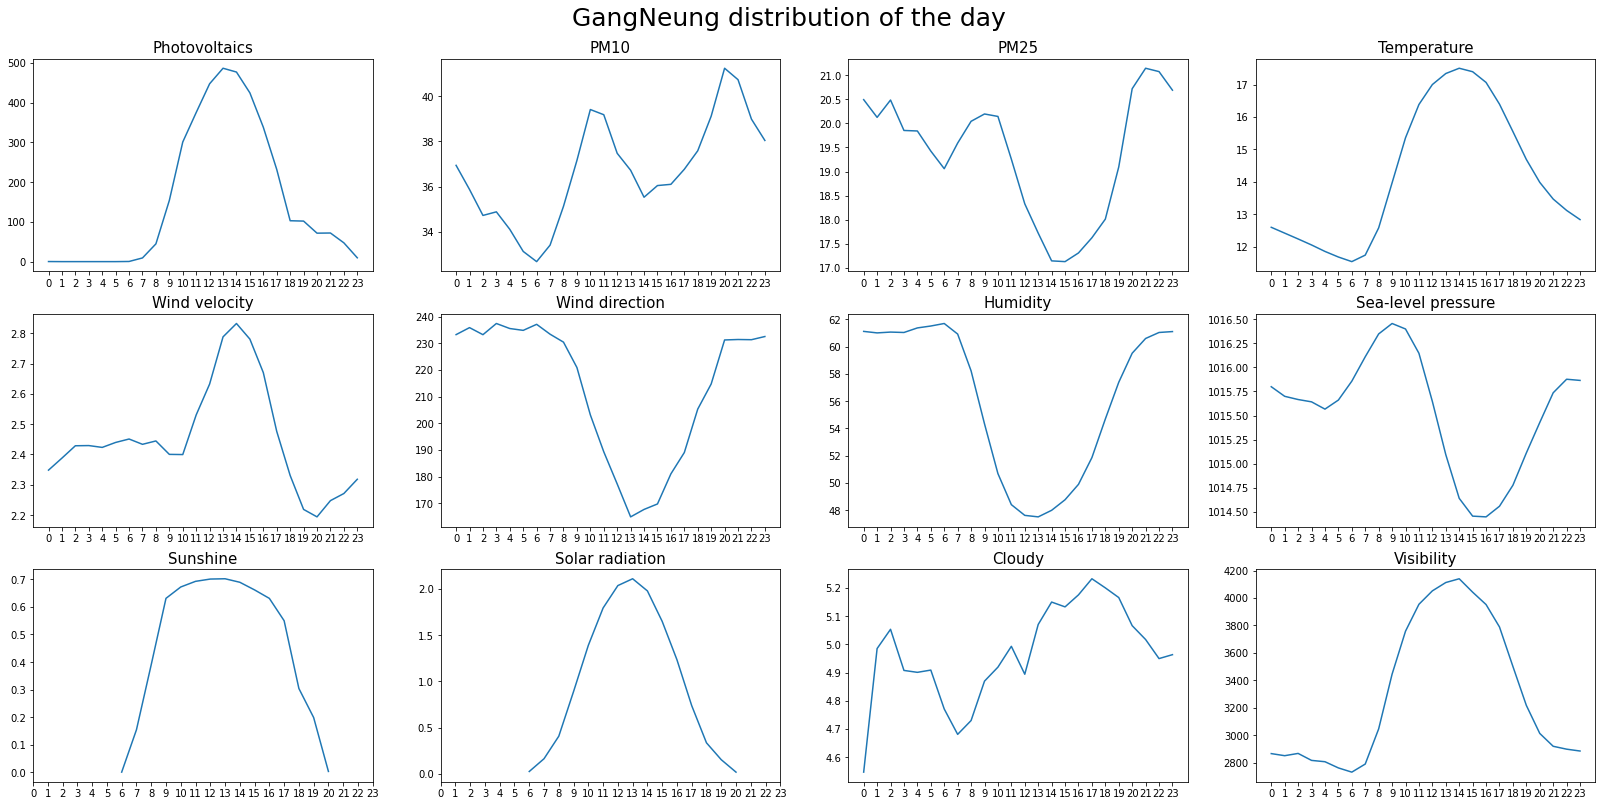

In [ ]:
Day_plot(Gn_df, 'GangNeung')

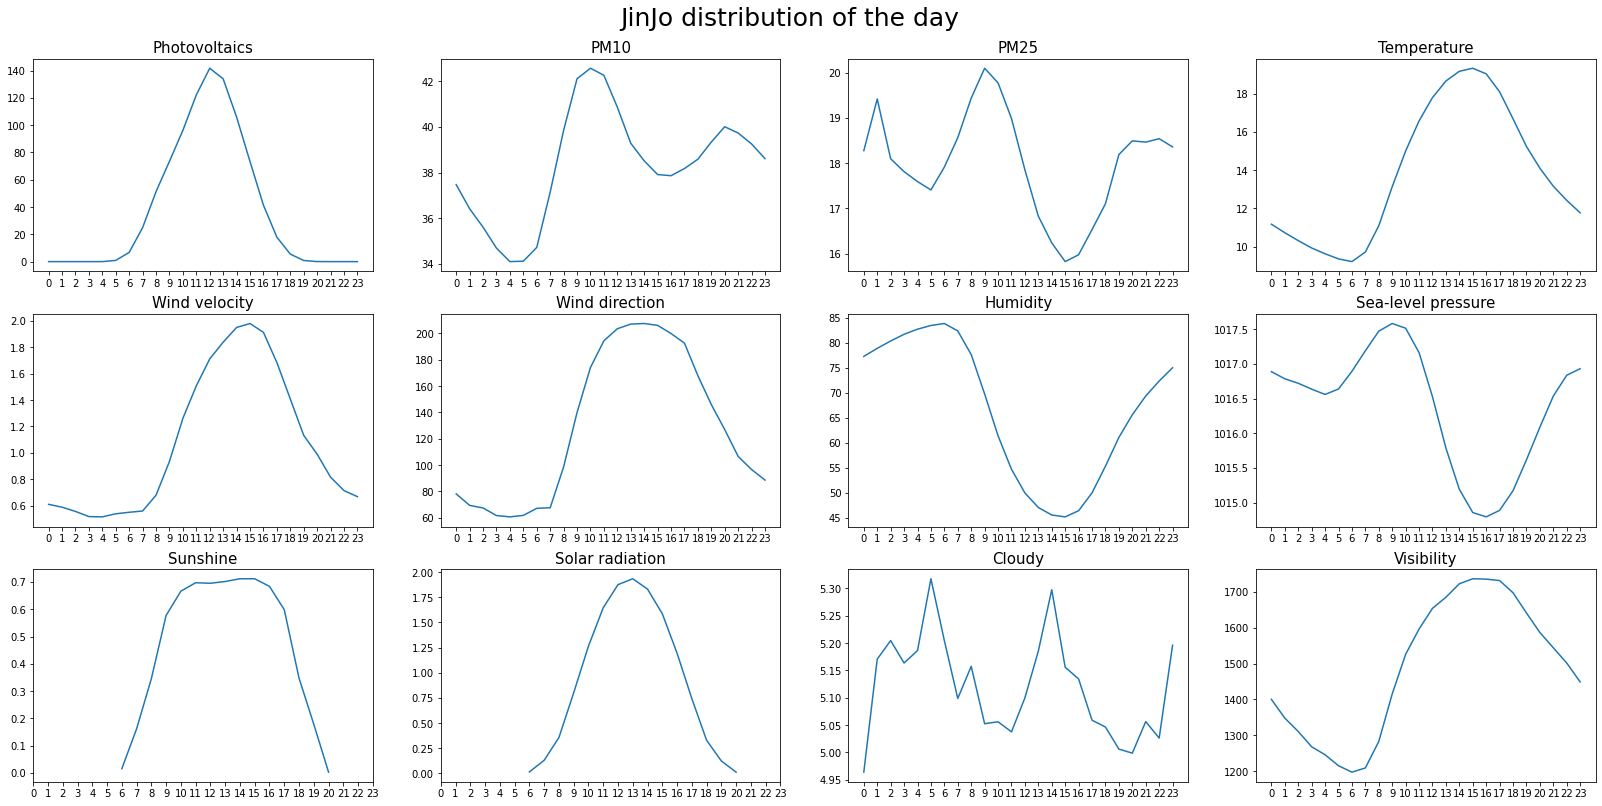

In [ ]:
Day_plot(Jj_df, 'JinJo')

# Correlation analysis

## Area

In [ ]:
cols = [i for i in df.columns if i not in ['Photovoltaics','Date', 'Area', 'Time', 'Month']]
cols.append('Photovoltaics')

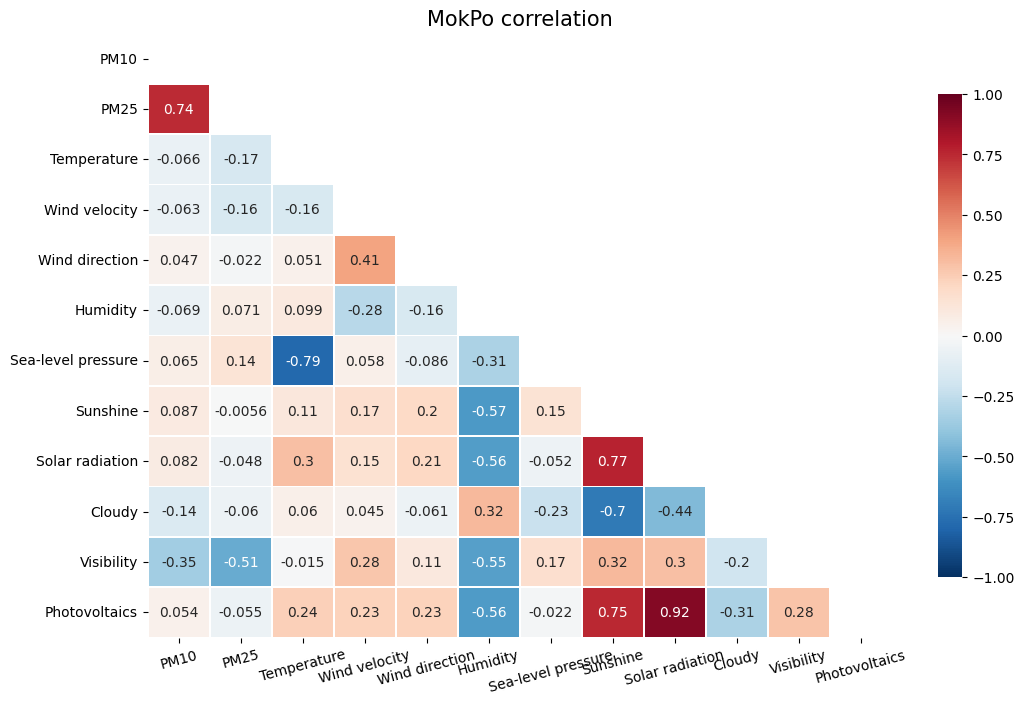

In [ ]:
corr_Mp = Correlation(Mp_df, cols, 'MokPo')

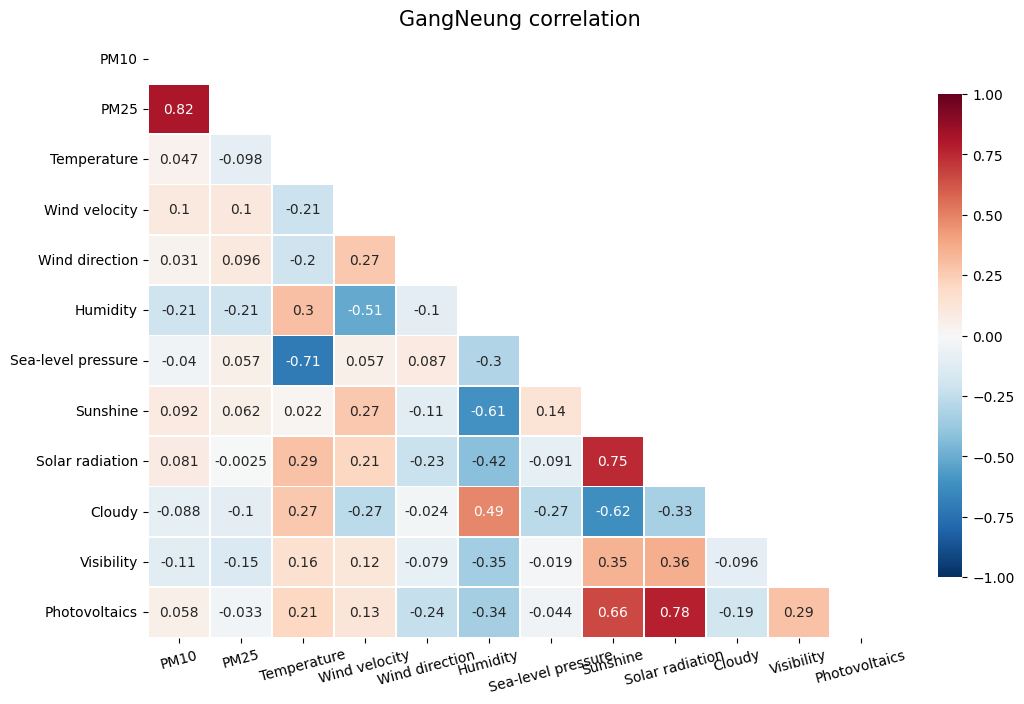

In [ ]:
corr_Gn = Correlation(Gn_df, cols, 'GangNeung')

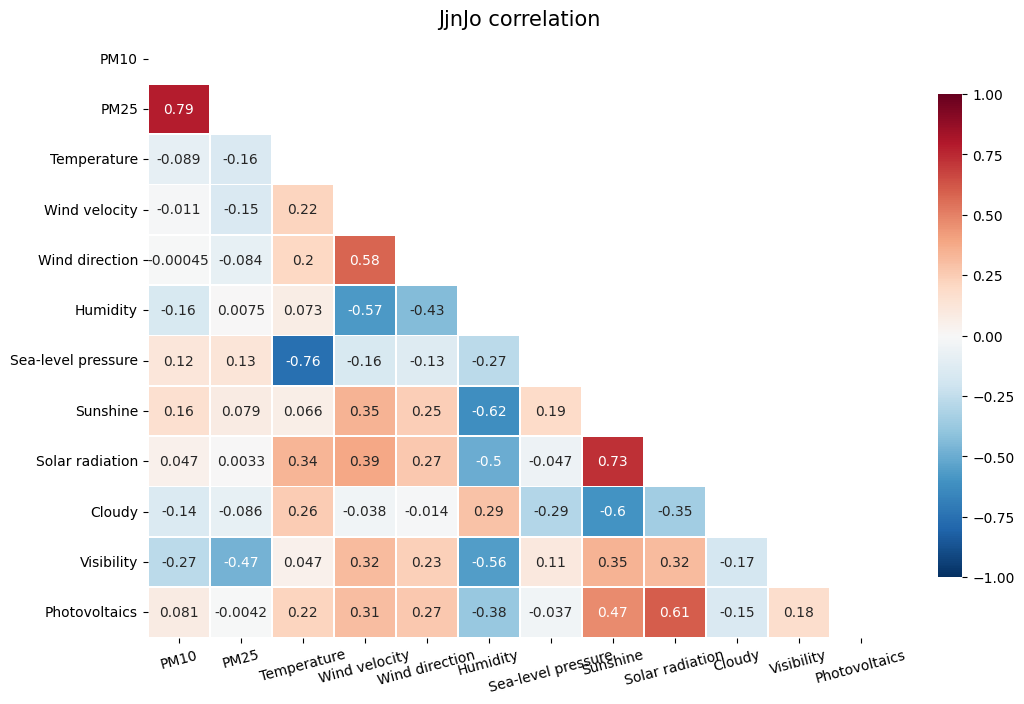

In [ ]:
corr_Jj = Correlation(Jj_df, cols, 'JjnJo')

## Season

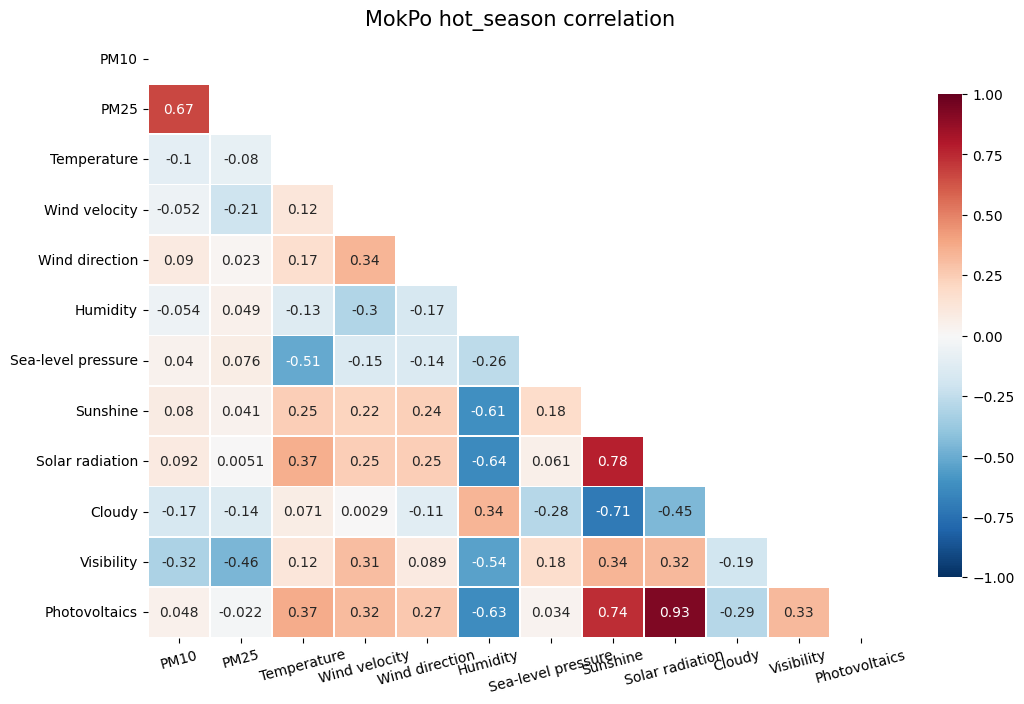

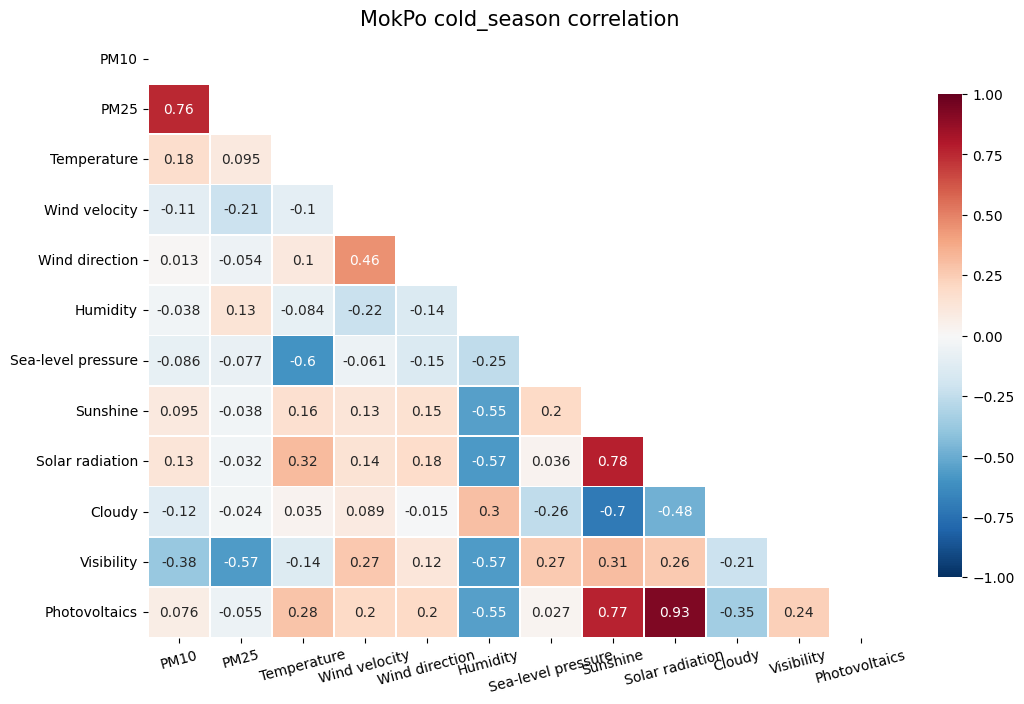

In [ ]:
hot_season, cold_season = SeasonSplit(Mp_df)
h = Correlation(hot_season, cols, 'MokPo hot_season')
c = Correlation(cold_season, cols, 'MokPo cold_season')

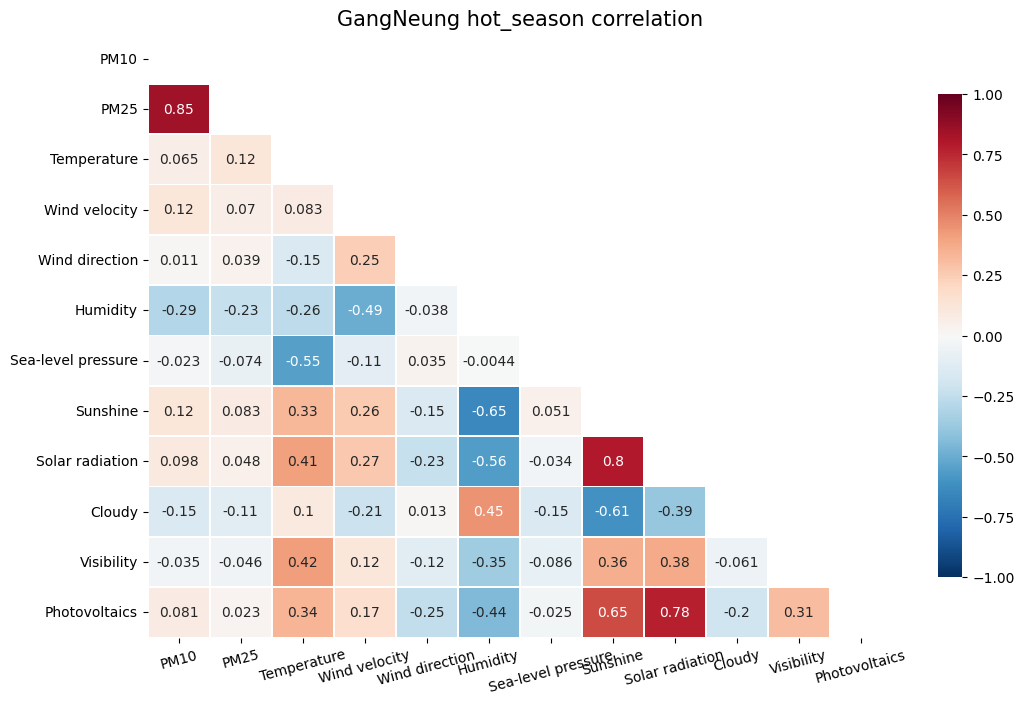

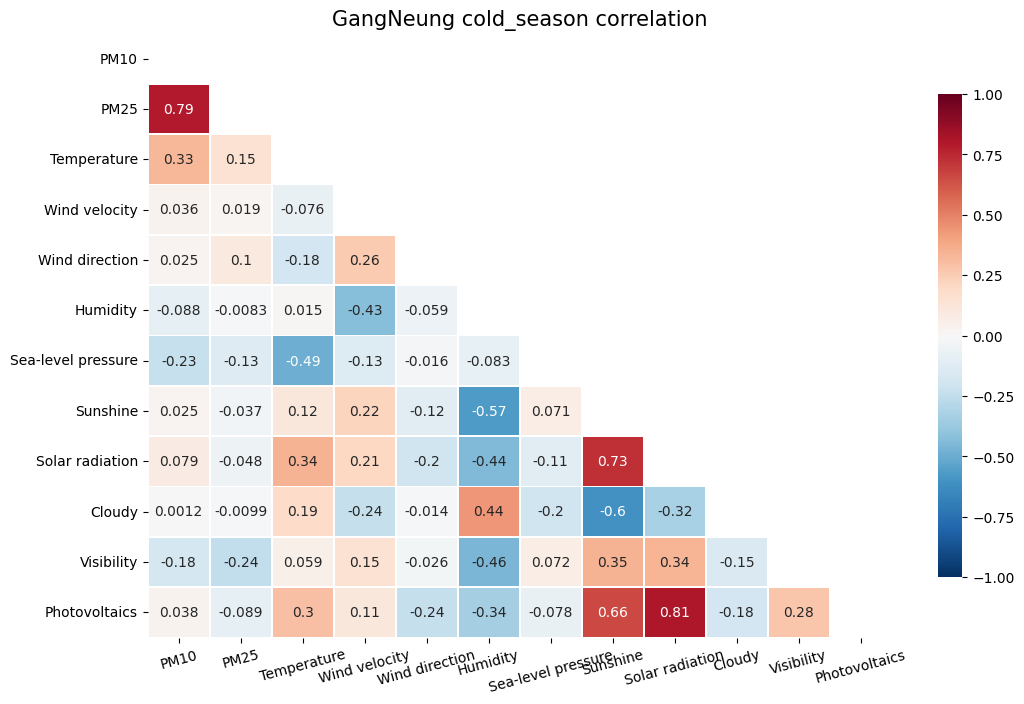

In [ ]:
hot_season, cold_season = SeasonSplit(Gn_df)
h = Correlation(hot_season, cols, 'GangNeung hot_season')
c = Correlation(cold_season, cols, 'GangNeung cold_season')

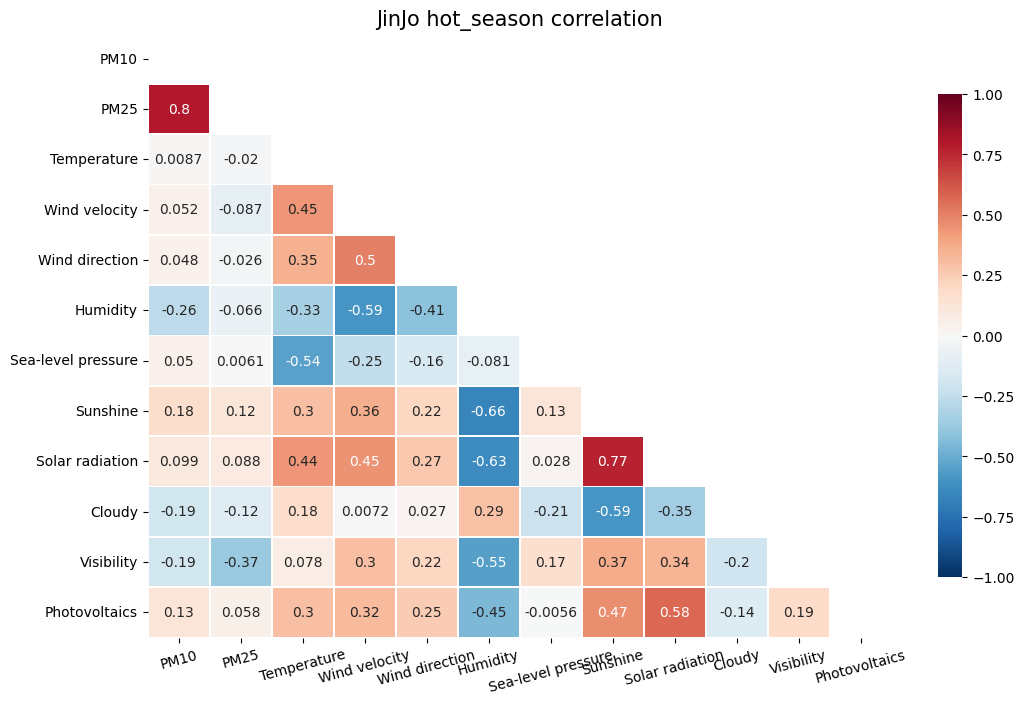

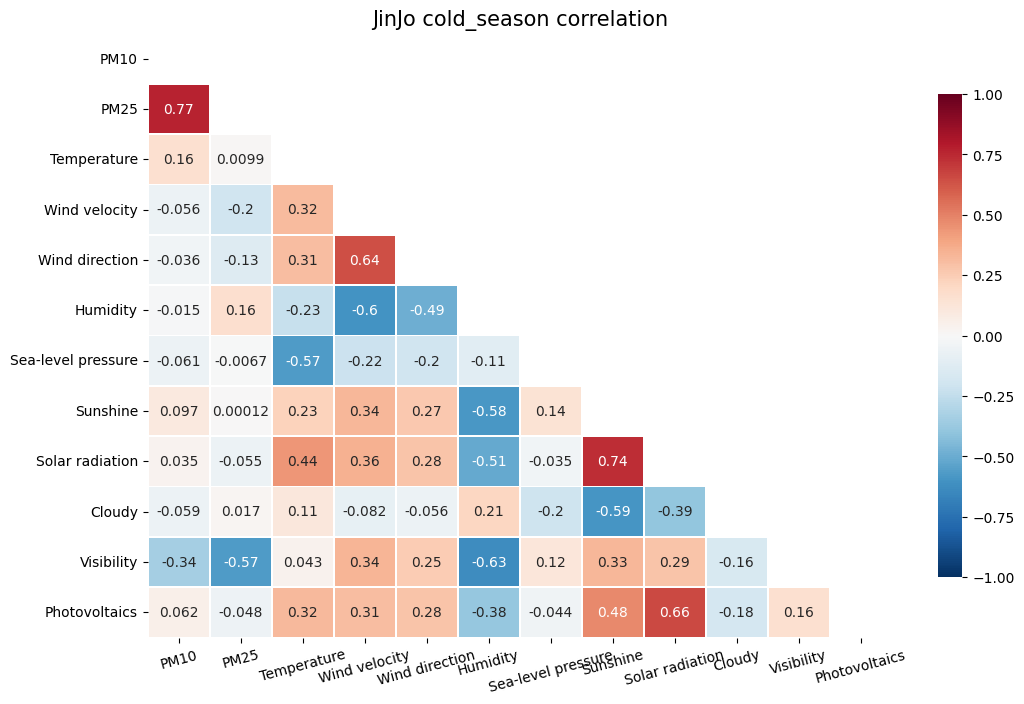

In [ ]:
hot_season, cold_season = SeasonSplit(Jj_df)
h = Correlation(hot_season, cols, 'JinJo hot_season')
c = Correlation(cold_season, cols, 'JinJo cold_season')

# highly correlated variable

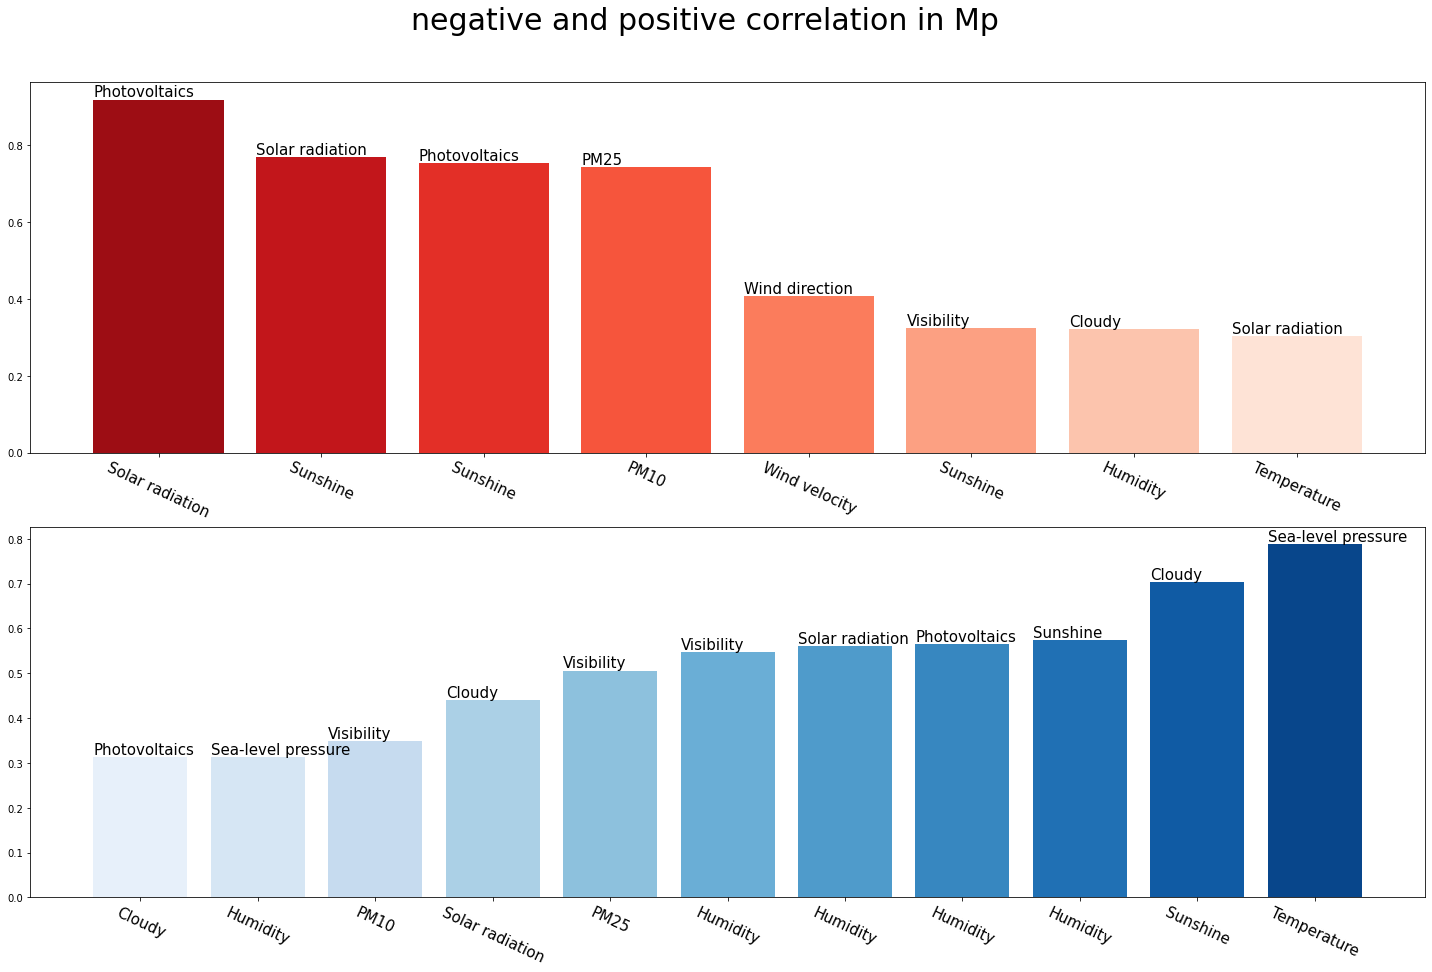

In [ ]:
Mp_data = CorrBar(corr_Mp, cols, 'Mp')

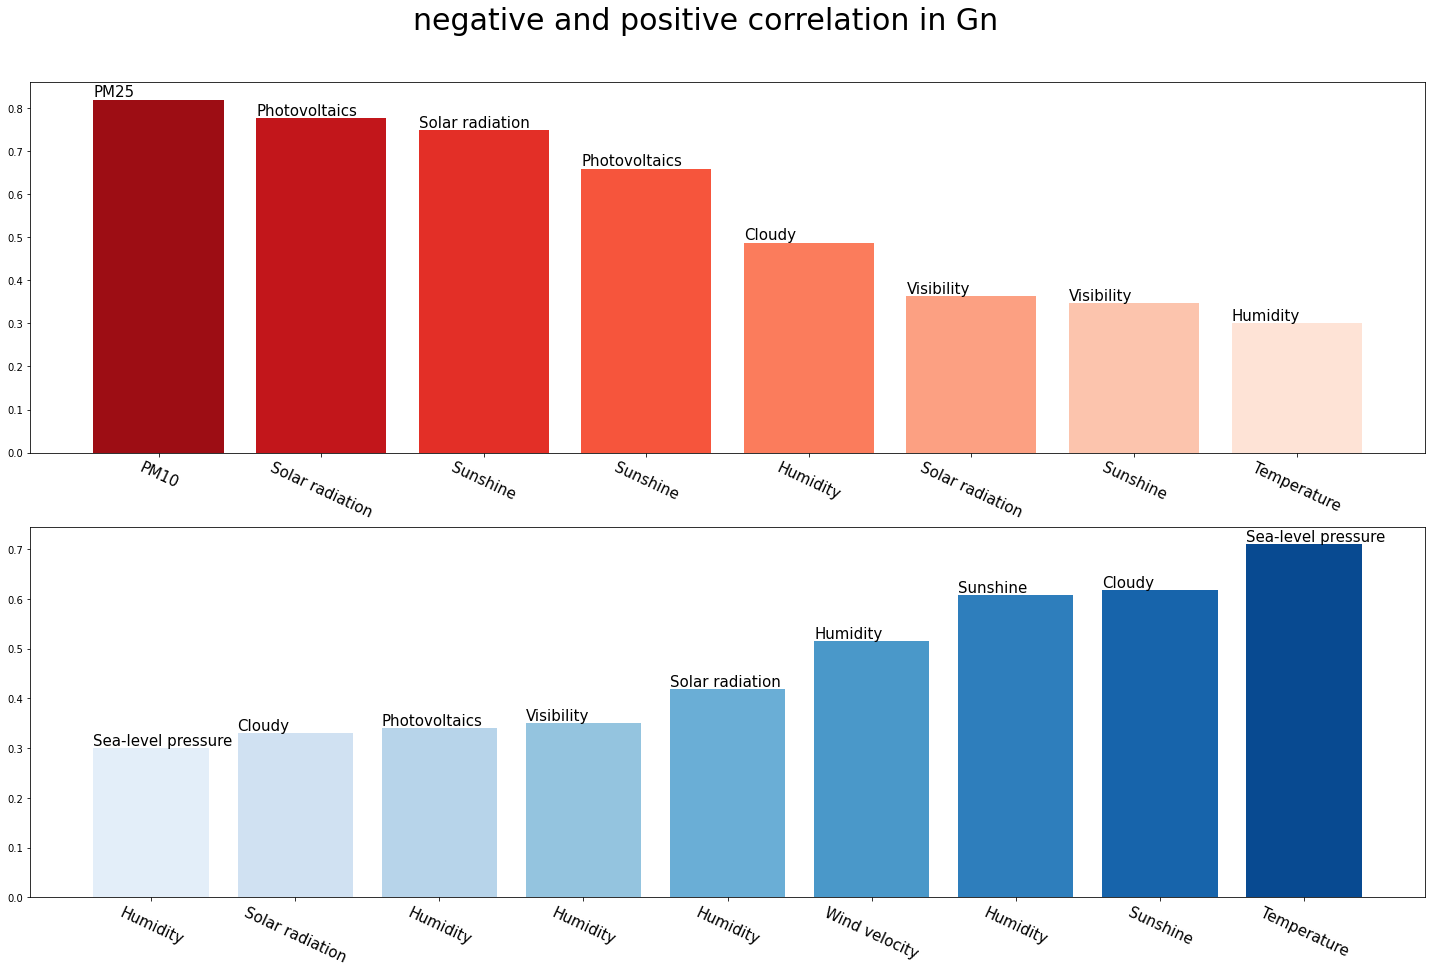

In [ ]:
Gn_data = CorrBar(corr_Gn, cols, 'Gn')

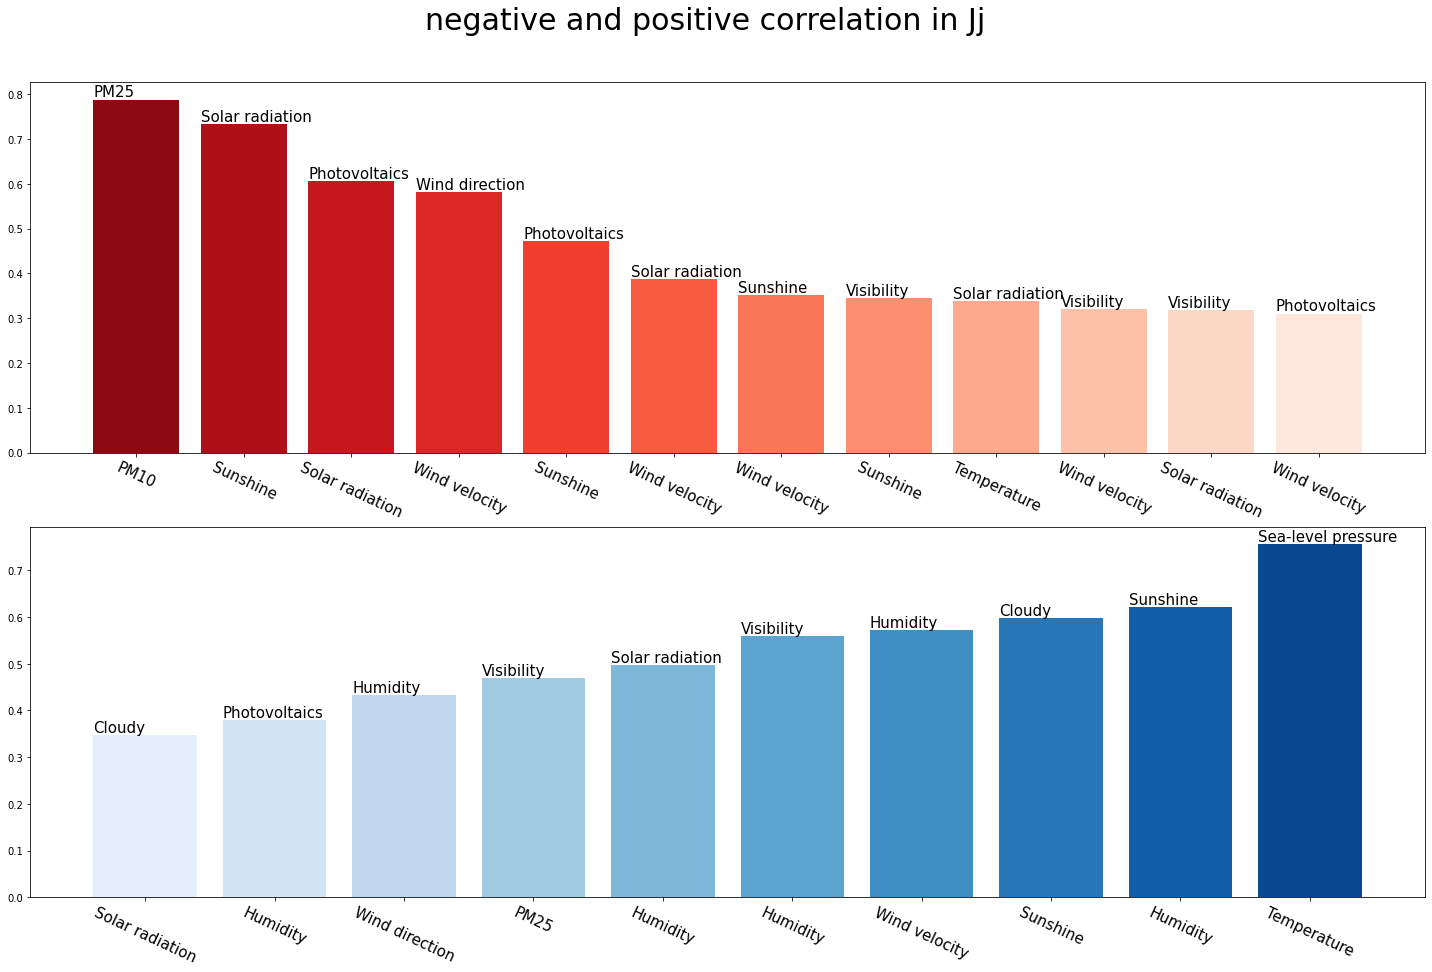

In [ ]:
Jj_data = CorrBar(corr_Jj, cols, 'Jj')

In [ ]:
corr_data = pd.concat([Mp_data, Gn_data, Jj_data], axis=1)
corr_data.columns = ['MokPo', 'corr', "GangNeung", 'corr', 'JinJo', 'corr']
corr_data

,MokPo,corr,GangNeung,corr,JinJo,corr
0,"(Solar radiation, Photovoltaics)",0.917781,"(PM10, PM25)",0.819937,"(PM10, PM25)",0.787854
1,"(Sunshine, Solar radiation)",0.767266,"(Solar radiation, Photovoltaics)",0.777456,"(Sunshine, Solar radiation)",0.733836
2,"(Sunshine, Photovoltaics)",0.753071,"(Sunshine, Solar radiation)",0.748925,"(Solar radiation, Photovoltaics)",0.605325
3,"(PM10, PM25)",0.742622,"(Sunshine, Photovoltaics)",0.659619,"(Wind velocity, Wind direction)",0.581168
4,"(Wind velocity, Wind direction)",0.406227,"(Humidity, Cloudy)",0.487744,"(Sunshine, Photovoltaics)",0.473017
...,...,...,...,...,...,...
61,"(Humidity, Solar radiation)",-0.560293,"(Humidity, Solar radiation)",-0.419236,"(Humidity, Visibility)",-0.558763
62,"(Humidity, Photovoltaics)",-0.564255,"(Wind velocity, Humidity)",-0.514536,"(Wind velocity, Humidity)",-0.572410
63,"(Humidity, Sunshine)",-0.573344,"(Humidity, Sunshine)",-0.607344,"(Sunshine, Cloudy)",-0.596848
64,"(Sunshine, Cloudy)",-0.703862,"(Sunshine, Cloudy)",-0.618054,"(Humidity, Sunshine)",-0.620692


# Remove variables

In [ ]:
df.drop(columns =['Sunshine','PM25'], inplace=True) #상관관계가 높은 일조-일사 , PM25-PM10 변수들 중 하나씩 제거 
df.head(3)

,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,1,0.0,44.0,-2.2,3.7,160.0,95.0,1021.3,NaN,NaN,NaN,1
1,2013-01-01,전남 목포시,2,0.0,34.0,-2.4,3.6,160.0,95.0,1021.2,NaN,NaN,NaN,1
2,2013-01-01,전남 목포시,3,0.0,41.0,-2.7,3.6,160.0,95.0,1020.8,NaN,7.0,1800.0,1


# Save 

In [ ]:
df.to_csv('/content/gdrive/MyDrive/SolarPower/MappingData.csv', index=None) 